In [76]:
# import
from collections import defaultdict
from functools import lru_cache
from tqdm import tqdm
import qiskit.circuit.random
import scipy.io as sio
import random
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
import numpy as np
import scipy.linalg as la
from qiskit.quantum_info import hellinger_fidelity
from qiskit.result import LocalReadoutMitigator
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
import jax
from qiskit.result import Counts
from jax import numpy as jnp
from jax import vmap
from qiskit_aer import AerSimulator
# from jax import random
from qiskit_aer.noise import NoiseModel, ReadoutError
import random
import math
import time
import psutil
import os

In [ ]:
# # def cartesian_coord(arr1, arr2):
# #     grid = np.meshgrid(arr2, arr1)
# #     coord_list = [entry.ravel() for entry in grid]
# #     points = np.vstack(coord_list).T
# #     return points

# # @jax.jit
# def kron_basis(arr1, arr2):
#     grid = jnp.meshgrid(arr2, arr1)
#     return grid[1].ravel() << 1 | grid[0].ravel()


# basis_1q = jnp.array([[0, 1], [1, 0]])
    
# @jax.jit
# def process_sample(local_basis, qubit, now_basis, now_values, all_local_vecs, threshold): 
#     next_basis = kron_basis(now_basis, basis_1q[local_basis])
#     next_values = jnp.kron(now_values, all_local_vecs[qubit][local_basis])
#     filter = jnp.logical_or(next_values > threshold, next_values < -threshold)
#     return next_basis, next_values, filter

# def sw_rm(qnum, stats_counts, meas_mats_inv, threshold=1e-10):
#     all_local_vecs = np.zeros(shape=(qnum, 2, 2))

#     for qubit in range(qnum):
#         for local_basis in (0, 1):
#             local_vec = np.zeros(2)
#             local_vec[local_basis] = 1
#             local_vec = meas_mats_inv[qubit] @ local_vec
#             all_local_vecs[qubit][local_basis] = local_vec

#     all_local_vecs = jnp.array(all_local_vecs)


#     rm_prob = defaultdict(float)
#     # for basis, count in tqdm(stats_counts.items()):
#     for basis, count in stats_counts.items():
#         basis = jnp.array([int(c) for c in basis])

#         now_basis = basis_1q[basis[0]]
#         now_values = all_local_vecs[0][basis[0]] * count
        
#         for qubit in range(1, qnum):
#             next_basis, next_values, filter = process_sample(basis[qubit], qubit, now_basis, now_values, all_local_vecs, threshold)
#             now_basis, now_values = next_basis[filter], next_values[filter]

#         for basis, value in zip(now_basis, now_values):
#             basis = int(basis)
#             # print(basis, value)
#             rm_prob[basis] += value

#     sum_prob = sum(rm_prob.values())
#     rm_prob = {
#         basis: value / sum_prob
#         for basis, value in rm_prob.items()
#     }
#     return rm_prob

In [73]:
# def cartesian_coord(arr1, arr2):
#     grid = np.meshgrid(arr2, arr1)
#     coord_list = [entry.ravel() for entry in grid]
#     points = np.vstack(coord_list).T
#     return points


def kron_basis(arr1, arr2):
    grid = np.meshgrid(arr2, arr1)
    return grid[1].ravel() << 1 | grid[0].ravel()

def sw_rm(qnum, stats_counts, meas_mats_inv, threshold=1e-10):
    all_local_vecs = np.zeros(shape=(qnum, 2, 2))

    for qubit in range(qnum):
        for local_basis in (0, 1):
            local_vec = np.zeros(2)
            local_vec[local_basis] = 1
            local_vec = meas_mats_inv[qubit] @ local_vec
            all_local_vecs[qubit][local_basis] = local_vec

    basis_1q = jnp.array([[0, 1], [1, 0]])

    rm_prob = defaultdict(float)
    # for basis, count in tqdm(stats_counts.items()):
    for basis, count in stats_counts.items():
        basis = [int(c) for c in basis]

        now_basis = basis_1q[basis[0]]
        now_values = all_local_vecs[0][basis[0]] * count

        for qubit in range(1, qnum):
            next_basis = kron_basis(now_basis, basis_1q[basis[0]])
            next_values = np.kron(now_values, all_local_vecs[qubit][basis[qubit]])
            
            filter = np.logical_or(next_values > threshold, next_values < -threshold)
            now_basis = next_basis[filter]
            now_values = next_values[filter]

        for basis, value in zip(now_basis, now_values):
            rm_prob[basis] += value

    sum_prob = sum(rm_prob.values())
    rm_prob = {
        basis: value / sum_prob
        for basis, value in rm_prob.items()
    }
    return rm_prob

In [74]:
def ghz(n_qubits):
    cir = QuantumCircuit(n_qubits)
    cir.h(0)
    for i in range(n_qubits - 1):
        cir.cx(i, i + 1)
    cir.measure_all()
    return cir

time_qiskit = []
time_sw = []
space_qiskit = []
space_sw = []

for n_qubits in range(5, 70):
    print(n_qubits)
    measure_fids = np.random.random(size=(n_qubits, 2))
    measure_fids = np.abs(measure_fids) / 10 + .9
    noise_model = NoiseModel()

    for i in range(n_qubits):
        re = ReadoutError([[measure_fids[i][0], 1 - measure_fids[i][0]],
                           [1 - measure_fids[i][1], measure_fids[i][1]]])
        noise_model.add_readout_error(re, qubits=[i])
    simulator = AerSimulator(noise_model=noise_model)
    noise_free_simulator = AerSimulator()
    
    n_samples = 3000
    before_rm_counts = simulator.run(
        ghz(n_qubits), shots=n_samples).result().get_counts()
    
    meas_mats, meas_mats_inv = [], []
    for qubit in range(n_qubits):
        meas_mat = np.array([[
            measure_fids[qubit][0], 1-measure_fids[qubit][1]],
            [1-measure_fids[qubit][0], measure_fids[qubit][1]]
        ])
        meas_mats.append(meas_mat)
        meas_mats_inv.append(np.linalg.inv(meas_mat))

    # if n_qubits < 16:
    #     mit = LocalReadoutMitigator(meas_mats, list(range(n_qubits)))
        
    #     start_time = time.time()
    #     qiskit_rm_prob = mit.quasi_probabilities(before_rm_counts)
    #     qiskit_rm_prob = {
    #         basis: value
    #         for basis, value in qiskit_rm_prob.items()
    #         if value > 1e-3
    #     }
    #     time_qiskit.append(time.time() - start_time)
        
    start_time = time.time()
    rm_prob = sw_rm(n_qubits, before_rm_counts, meas_mats_inv, threshold=n_samples * 1e-5)
    time_sw.append(time.time() - start_time)
    

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [ ]:
# time_sw = [time_sw[i] for i in range(70)]
plt.plot(list(range(len(time_qiskit))), time_qiskit)
plt.plot(list(range(len(time_sw))), time_sw)
plt.xlabel("Qubit")
plt.ylabel("Time (s)")
plt.yscale('log')

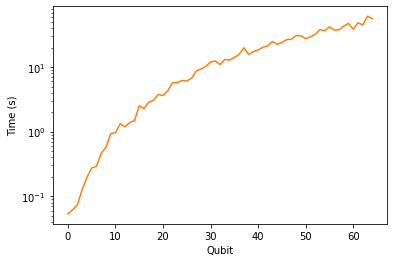

In [75]:
# time_sw = [time_sw[i] for i in range(70)]
plt.plot(list(range(len(time_qiskit))), time_qiskit)
plt.plot(list(range(len(time_sw))), time_sw)
plt.xlabel("Qubit")
plt.ylabel("Time (s)")
plt.yscale('log')

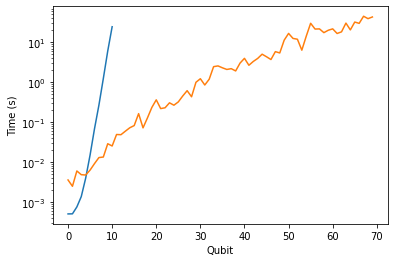

In [ ]:
time_sw = [time_sw[i] for i in range(70)]
plt.plot(list(range(len(time_qiskit))), time_qiskit)
plt.plot(list(range(len(time_sw))), time_sw)
plt.xlabel("Qubit")
plt.ylabel("Time (s)")
plt.yscale('log')

In [39]:
import numpy as np
# np.kron()
a = np.array([0, 1])
b = np.array([2, 3])
# np.tensordot(a, a)

def cartesian_coord(arr1, arr2):
    grid = np.meshgrid(arr2, arr1)
    coord_list = [entry.ravel() for entry in grid]
    # print(coord_list[0] << 1 | coord_list[0])
    print(coord_list[0] << 1 | coord_list[1])
    points = np.vstack(coord_list).T
    return points

cartesian_coord(a, b), np.kron(a, b)


[4 6 5 7]


(array([[2, 0],
        [3, 0],
        [2, 1],
        [3, 1]]),
 array([0, 0, 2, 3]))

In [82]:
import scipy as sp
def nearest_unitary(A):
    """
    Calculate the closest unitary to a given matrix.

    Calculate the unitary matrix U that is closest with respect to the
    operator norm distance to the general matrix A.

    D.M.Reich. "Characterisation and Identification of Unitary Dynamics
    Maps in Terms of Their Action on Density Matrices"

    Args:
        A (np.ndarray): The matrix input.

    Returns:
        (np.ndarray): The unitary matrix closest to A.
        Return U as a numpy matrix.

    Thank you to Ed Younis, this is based on code from baseline.qfast
    """
    try:
        if len(A.shape) == 2 and A.shape[0] != A.shape[1]:
            raise TypeError("A must be a square matrix.")

        V, __, Wh = sp.linalg.svd(A)
        U = np.array(V.dot(Wh))
        return U
    except Exception:
        return A
    
measure_fids0 = 0.90
measure_fids1 = 0.95
M = np.array([[measure_fids0, 1 - measure_fids0],
    [1 - measure_fids1, measure_fids1]])
M @ M.T.conj()


array([[0.82 , 0.14 ],
       [0.14 , 0.905]])

In [84]:
uM = nearest_unitary(M)
uM @ uM.T.conj()

array([[1.00000000e+00, 1.64340319e-16],
       [1.64340319e-16, 1.00000000e+00]])

In [85]:
M, uM

(array([[0.9 , 0.1 ],
        [0.05, 0.95]]),
 array([[ 0.99963497,  0.02701716],
        [-0.02701716,  0.99963497]]))

In [87]:

import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from tqdm import tqdm

from jax import numpy as jnp
import jax
import time
from functools import lru_cache
from line_profiler import LineProfiler

qnum = 24
stats01s = sio.loadmat(f'{qnum}qubit_data/stats_0.mat')['stats01s']
stats01s

array([[[1, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 1, ..., 0, 1, 0],
        [0, 1, 0, ..., 0, 0, 1],
        [0, 0, 1, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 1, 1, 1],
        [0, 1, 0, ..., 1, 0, 1]],

       [[1, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        ...,
        [1, 0, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 1, 0, 0]],

       ...,

       [[1, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 1, 1, ..., 1, 0, 1],
        [1, 0, 1, ..., 1, 0, 1]],

       [[1, 0, 0, ..., 1, 1, 0],
        [1, 1, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        ...,
        [1, 1, 0, ..., 